In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

### Divide the images into equal patches

In [2]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

### Positional Embeddings
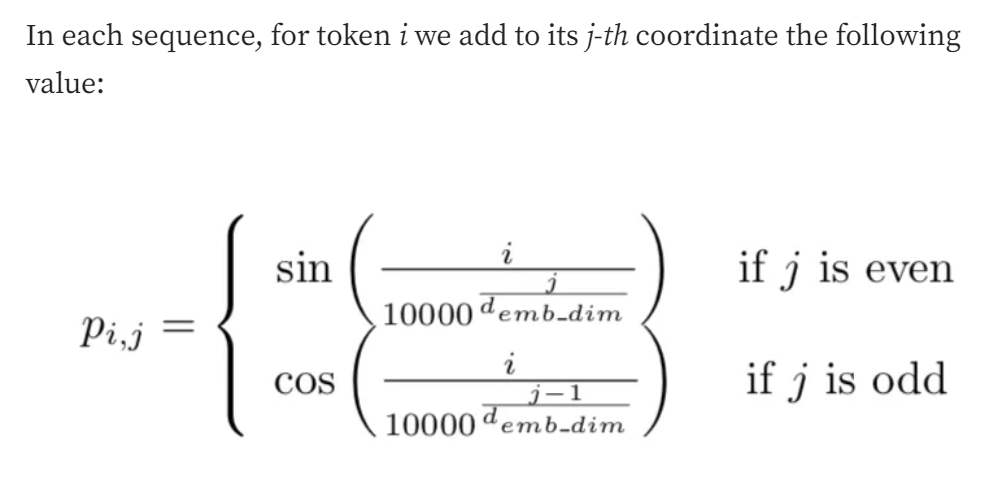

In [3]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

### Multi-Head Self-attention

In [4]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### Encoder Block

In [5]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [6]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

### Training and testing loop

In [7]:
# def main():
    # Loading data
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 5
LR = 0.005

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

100%|██████████| 9912422/9912422 [00:00<00:00, 114322631.08it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24202935.83it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45767567.76it/s]

Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25502715.89it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Using device:  cuda (Tesla T4)


Testing: 100%|██████████| 79/79 [00:31<00:00,  2.49it/s]

Test loss: 1.70
Test accuracy: 76.22%
